In [4]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_selection import f_classif
from sklearn.neighbors import NearestNeighbors

# Data Preparation

In [5]:
# Reading Data
genes = pd.read_csv("/Users/cyclops/Desktop/UChicago/Second year/Winter/Mathematical Methods for Biological Sciences II/Final Project/Data/sampled_genes.csv")
stats = pd.read_csv("/Users/cyclops/Desktop/UChicago/Second year/Winter/Mathematical Methods for Biological Sciences II/Final Project/Data/sampled_stats.csv")
genes_expression_transposed = genes.iloc[:, 6:].transpose().reset_index().rename(columns={"index": "StudyID"})
genes_combined = pd.merge(genes_expression_transposed, stats, on="StudyID", how="left")
# genes_combined.iloc[list(genes_combined["StudyID"]).index(""), 15645:]

# Assigning Group to Asthma
conditions = [
    (genes_combined["asthma_age7"] == "Yes") & (genes_combined["asthma_age10"] == "Yes"),  
    (genes_combined["asthma_age7"] == "No") & (genes_combined["asthma_age10"] == "No"),    
    (genes_combined["asthma_age7"] == "Yes") & (genes_combined["asthma_age10"] == "No"),   
    (genes_combined["asthma_age7"] == "No") & (genes_combined["asthma_age10"] == "Yes")    
]
values = [1, 2, 3, 4]
genes_combined["Asthma_Group"] = np.select(conditions, values, default=np.nan)
genes_combined["Asthma_Group"] = genes_combined["Asthma_Group"].astype(int)

# Extracting Traits
gender_index = list(genes_combined.columns).index("Sex")
gender = genes_combined.iloc[:, gender_index]
group_index = list(genes_combined.columns).index("Asthma_Group")
group = genes_combined.iloc[:, group_index]
genes_expression = genes_combined.iloc[:, 1:gender_index]

genes_combined_1 = pd.merge(genes_expression_transposed, stats, on="StudyID", how="left")
genes_combined_1["Current_Status"] = genes_combined_1["asthma_age10"].apply(lambda x: 0 if x == "No" else 1)
two_group_index = list(genes_combined_1.columns).index("Current_Status")
two_group = genes_combined_1.iloc[:, group_index]
genes_expression_1 = genes_combined_1.iloc[:, 1:gender_index]

In [6]:
# Evaluation: Nearest Neighbor Conservation
def compute_agreement_score(original, reduced, n_neighbors=10):
    neighbors_original = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(original)
    distance_original, indices_original = neighbors_original.kneighbors(original)
    neighbors_reduced = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(reduced)
    distance_reduced, indices_reduced = neighbors_reduced.kneighbors(reduced)
    agreement_scores = []
    for i in range(original.shape[0]):
        intersection = set(indices_original[i, 1:]).intersection(set(indices_reduced[i, 1:]))
        agreement_score = len(intersection) / n_neighbors
        agreement_scores.append(agreement_score)                                                                             
    return np.array(agreement_scores)

# Unfiltered Data
## Four Asthma Status

In [7]:
# Dimensionality Reduction: PCA
pca = PCA(2)
result = pca.fit_transform(genes_expression)

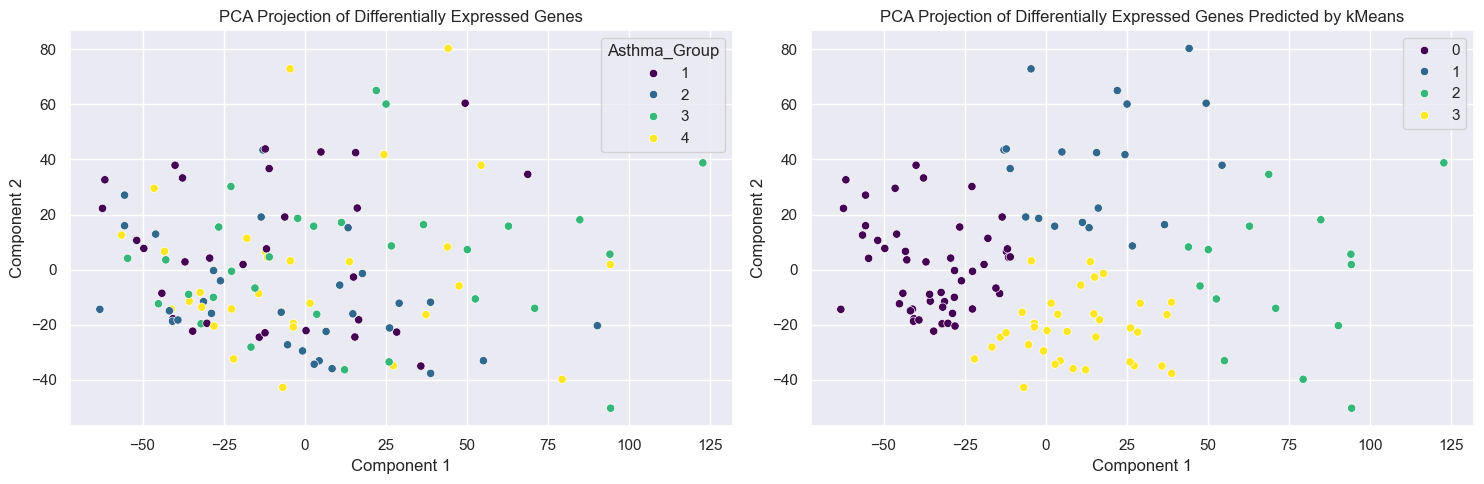

In [8]:
# Perform KMeans Clustering to Predict Asthma Status
kmeans = KMeans(n_clusters = 4)
predicted_group = kmeans.fit_predict(result)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x=result[:, 0], y=result[:, 1], hue=group, palette="viridis", ax=axes[0])
axes[0].set_title("PCA Projection of Differentially Expressed Genes")
axes[0].set_xlabel("Component 1")
axes[0].set_ylabel("Component 2")

sns.scatterplot(x=result[:, 0], y=result[:, 1], hue=predicted_group, palette="viridis", ax=axes[1])
axes[1].set_title("PCA Projection of Differentially Expressed Genes Predicted by kMeans")
axes[1].set_xlabel("Component 1")
axes[1].set_ylabel("Component 2")

plt.tight_layout()
plt.show()


## Gender

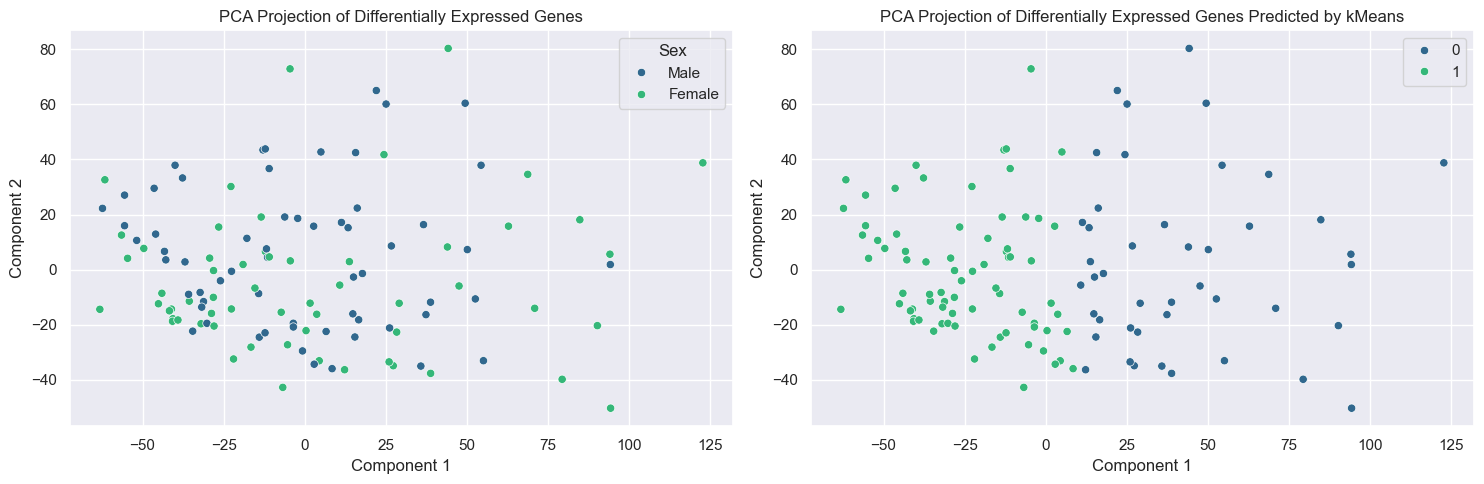

In [9]:
# Perform KMeans Clustering to Predict Gender
kmeans = KMeans(n_clusters = 2)
predicted_gender_group = kmeans.fit_predict(result)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x=result[:, 0], y=result[:, 1], hue=gender, palette="viridis", ax=axes[0])
axes[0].set_title("PCA Projection of Differentially Expressed Genes")
axes[0].set_xlabel("Component 1")
axes[0].set_ylabel("Component 2")

sns.scatterplot(x=result[:, 0], y=result[:, 1], hue=predicted_gender_group, palette="viridis", ax=axes[1])
axes[1].set_title("PCA Projection of Differentially Expressed Genes Predicted by kMeans")
axes[1].set_xlabel("Component 1")
axes[1].set_ylabel("Component 2")

plt.tight_layout()
plt.show()

# Filtered Data
## Four Asthma Status

In [10]:
genes = pd.read_csv("/Users/cyclops/Desktop/UChicago/Second year/Winter/Mathematical Methods for Biological Sciences II/Final Project/Data/significant_genes_asthma.csv")
significant_genes = genes.iloc[:, 6:].transpose()

In [11]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(significant_genes)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# tSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(significant_genes)

# kMeans for PCA
kmeans = KMeans(n_clusters = 4)
predicted_pca_group = kmeans.fit_predict(pca_result)

# kMeans for tSNE
kmeans = KMeans(n_clusters = 4)
predicted_tsne_group = kmeans.fit_predict(tsne_result)

Explained Variance Ratio: [0.13343663 0.07238411]


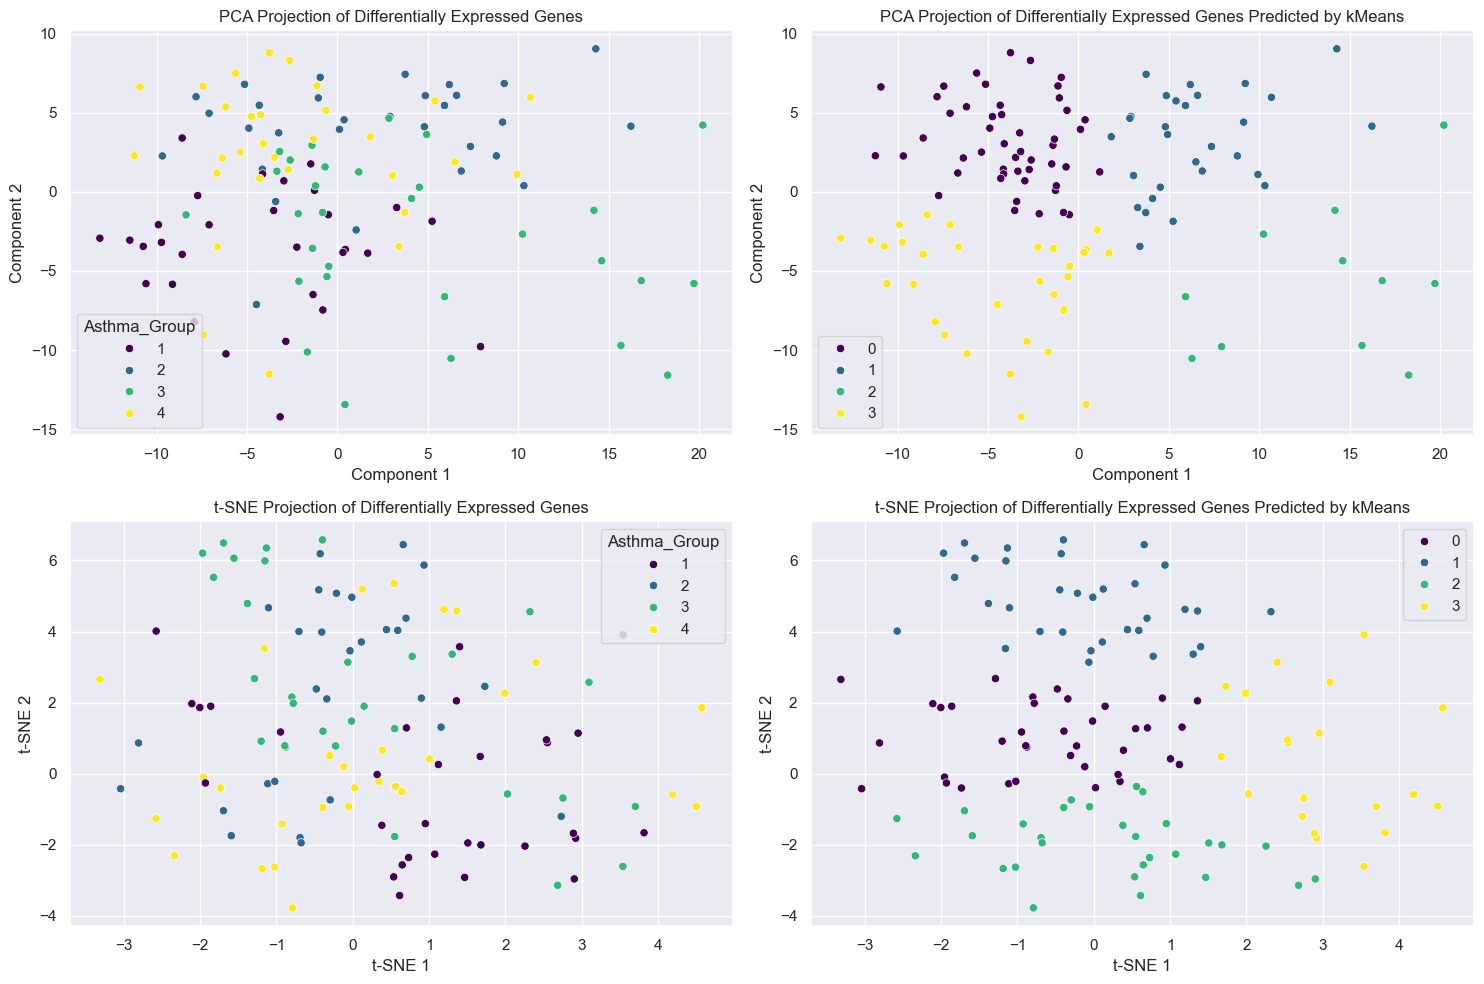

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=group, palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title("PCA Projection of Differentially Expressed Genes")
axes[0, 0].set_xlabel("Component 1")
axes[0, 0].set_ylabel("Component 2")

sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=group, palette="viridis", ax=axes[1, 0])
axes[1, 0].set_title("t-SNE Projection of Differentially Expressed Genes")
axes[1, 0].set_xlabel("t-SNE 1")
axes[1, 0].set_ylabel("t-SNE 2")

sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=predicted_pca_group, palette="viridis", ax=axes[0, 1])
axes[0, 1].set_title("PCA Projection of Differentially Expressed Genes Predicted by kMeans")
axes[0, 1].set_xlabel("Component 1")
axes[0, 1].set_ylabel("Component 2")


sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=predicted_tsne_group, palette="viridis", ax=axes[1, 1])
axes[1, 1].set_title("t-SNE Projection of Differentially Expressed Genes Predicted by kMeans")
axes[1, 1].set_xlabel("t-SNE 1")
axes[1, 1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

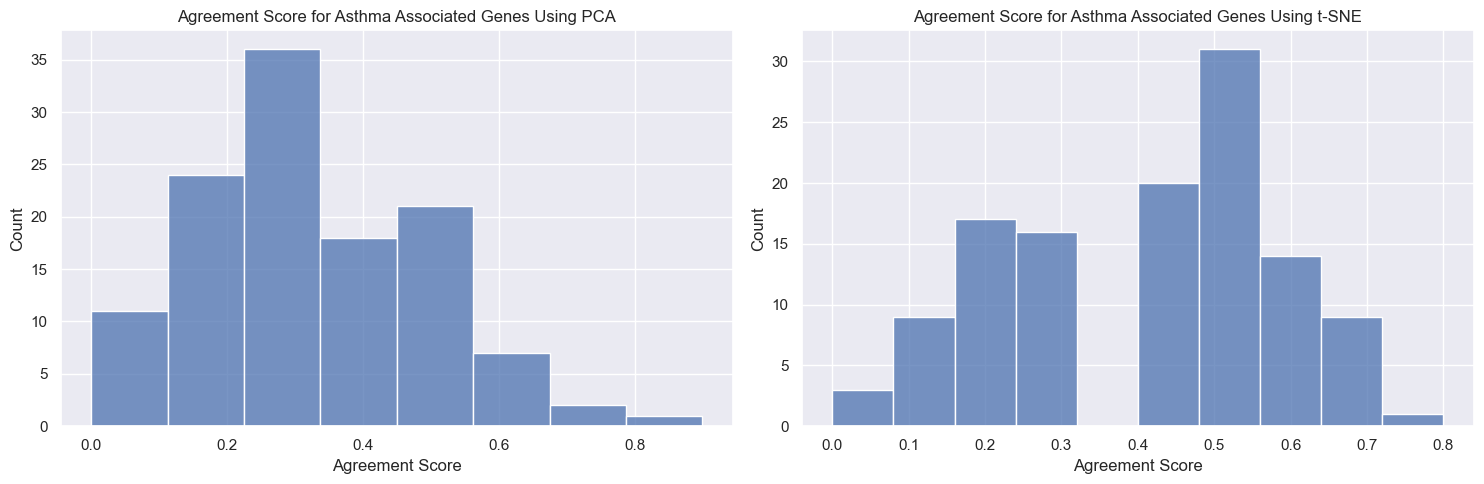

PCA Percentage of top 10 nearest neighbors retained: 0.33999999999999997
PCA Standard deviation of agreement scores: 0.15459624833740307
t-SNE Percentage of top 10 nearest neighbors retained: 0.4008333333333333
t-SNE Standard deviation of agreement scores: 0.18188633508015076


In [13]:
pca_agreement_score = compute_agreement_score(significant_genes, pca_result)
tsne_agreement_score = compute_agreement_score(significant_genes, tsne_result)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(x=pca_agreement_score, ax=axes[0])
axes[0].set_title("Agreement Score for Asthma Associated Genes Using PCA")
axes[0].set_xlabel("Agreement Score")

sns.histplot(x=tsne_agreement_score, ax=axes[1])
axes[1].set_title("Agreement Score for Asthma Associated Genes Using t-SNE")
axes[1].set_xlabel("Agreement Score")

plt.tight_layout()
plt.show()

print(f"PCA Percentage of top 10 nearest neighbors retained: {np.mean(pca_agreement_score)}")
print(f"PCA Standard deviation of agreement scores: {np.std(pca_agreement_score)}")
print(f"t-SNE Percentage of top 10 nearest neighbors retained: {np.mean(tsne_agreement_score)}")
print(f"t-SNE Standard deviation of agreement scores: {np.std(tsne_agreement_score)}")

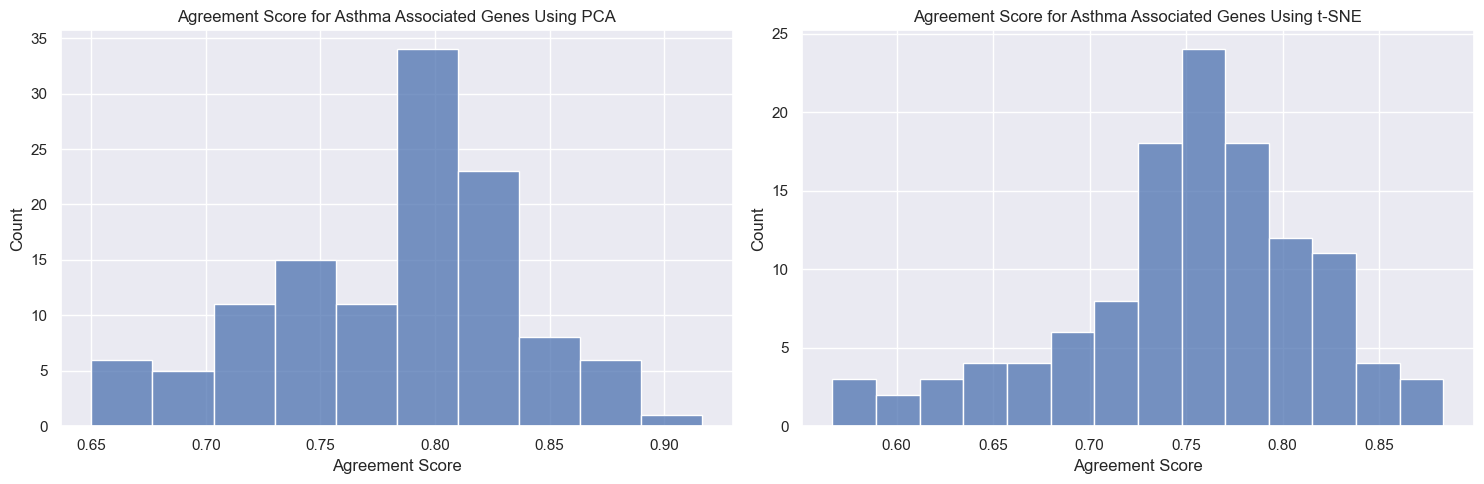

PCA Percentage of top 60 nearest neighbors retained: 0.7812500000000001
PCA Standard deviation of agreement scores: 0.05559286941352847
t-SNE Percentage of top 60 nearest neighbors retained: 0.7513888888888888
t-SNE Standard deviation of agreement scores: 0.06315704021243446


In [14]:
pca_agreement_score = compute_agreement_score(significant_genes, pca_result, n_neighbors=60)
tsne_agreement_score = compute_agreement_score(significant_genes, tsne_result, n_neighbors=60)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(x=pca_agreement_score, ax=axes[0])
axes[0].set_title("Agreement Score for Asthma Associated Genes Using PCA")
axes[0].set_xlabel("Agreement Score")

sns.histplot(x=tsne_agreement_score, ax=axes[1])
axes[1].set_title("Agreement Score for Asthma Associated Genes Using t-SNE")
axes[1].set_xlabel("Agreement Score")

plt.tight_layout()
plt.show()

print(f"PCA Percentage of top 60 nearest neighbors retained: {np.mean(pca_agreement_score)}")
print(f"PCA Standard deviation of agreement scores: {np.std(pca_agreement_score)}")
print(f"t-SNE Percentage of top 60 nearest neighbors retained: {np.mean(tsne_agreement_score)}")
print(f"t-SNE Standard deviation of agreement scores: {np.std(tsne_agreement_score)}")

## Gender

In [15]:
f_scores, p_values = f_classif(genes_expression, gender)
gene_stats = pd.DataFrame({
    "Gene": genes_combined.columns[1:gender_index], 
    "F_score": f_scores,
    "p_value": p_values
})
gene_stats_sorted = gene_stats.sort_values(by="p_value")
print(gene_stats_sorted.head())

p_value_threshold = 0.01
significant_genes = gene_stats_sorted[gene_stats_sorted["p_value"] < p_value_threshold]
significant_gene_indices = list(significant_genes.index)
selected_genes = genes_expression.iloc[:, significant_gene_indices]
print("Filtered gene expression shape:", selected_genes.shape)

        Gene      F_score       p_value
15638  15638  2614.696099  2.273267e-82
15635  15635  2382.734187  4.270217e-80
15642  15642  2323.139904  1.773066e-79
15634  15634  2255.430208  9.328038e-79
15643  15643  2195.488258  4.222022e-78
Filtered gene expression shape: (120, 329)


In [16]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(selected_genes)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# tSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(selected_genes)

# kMeans for PCA
kmeans = KMeans(n_clusters = 2)
predicted_pca_group = kmeans.fit_predict(pca_result)

# kMeans for tSNE
kmeans = KMeans(n_clusters = 2)
predicted_tsne_group = kmeans.fit_predict(tsne_result)

Explained Variance Ratio: [0.33422437 0.12546818]


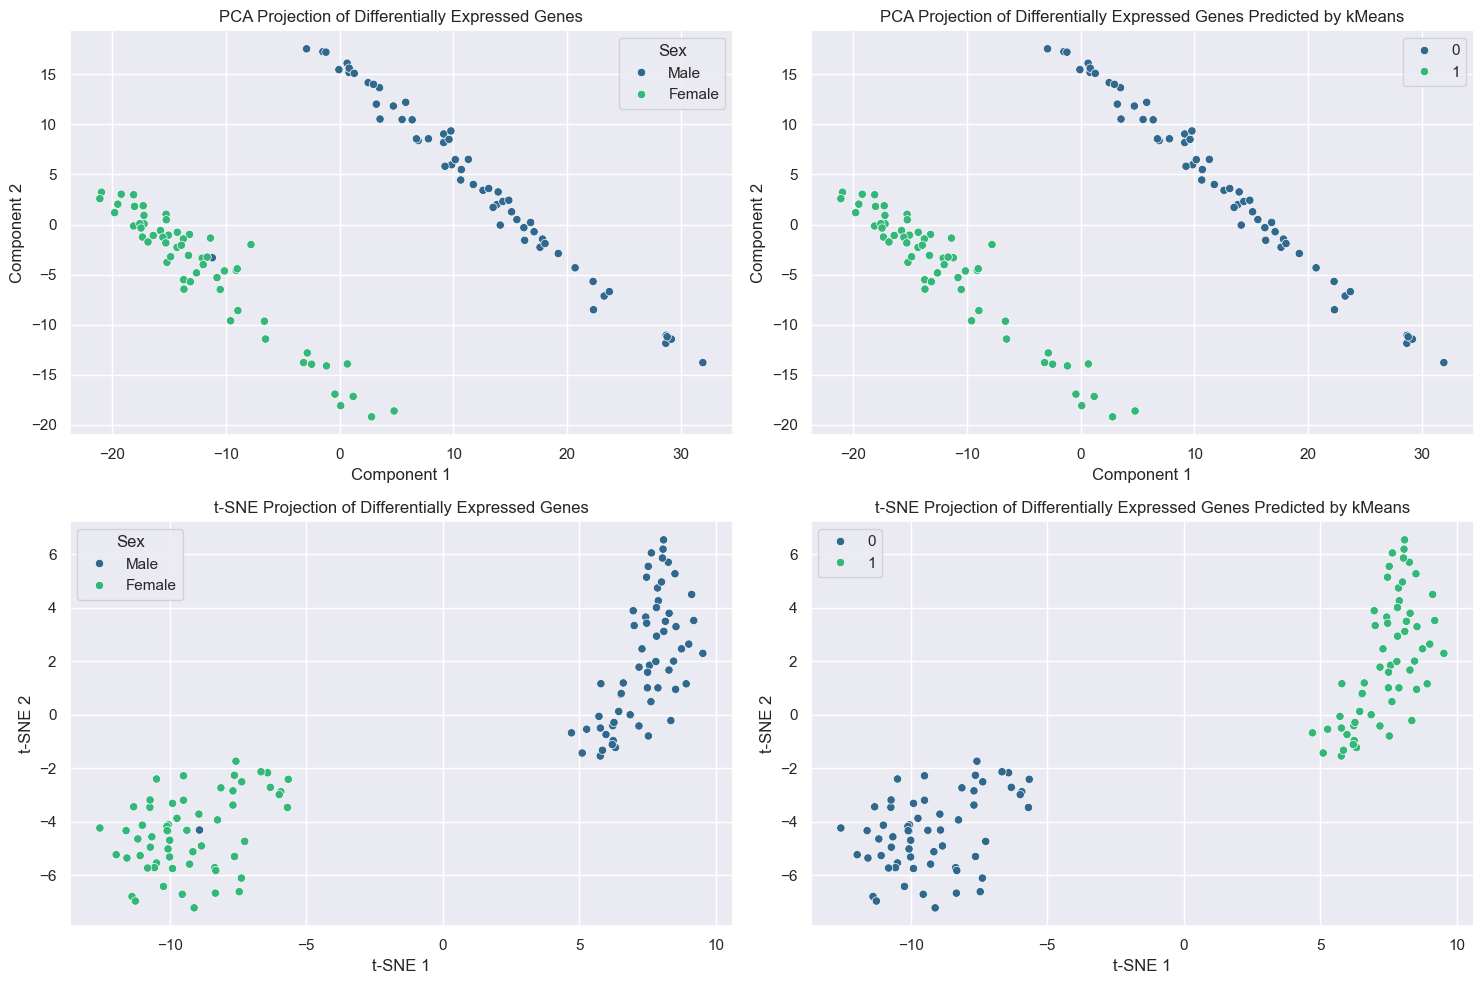

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=gender, palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title("PCA Projection of Differentially Expressed Genes")
axes[0, 0].set_xlabel("Component 1")
axes[0, 0].set_ylabel("Component 2")

sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=gender, palette="viridis", ax=axes[1, 0])
axes[1, 0].set_title("t-SNE Projection of Differentially Expressed Genes")
axes[1, 0].set_xlabel("t-SNE 1")
axes[1, 0].set_ylabel("t-SNE 2")

sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=predicted_pca_group, palette="viridis", ax=axes[0, 1])
axes[0, 1].set_title("PCA Projection of Differentially Expressed Genes Predicted by kMeans")
axes[0, 1].set_xlabel("Component 1")
axes[0, 1].set_ylabel("Component 2")

sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=predicted_tsne_group, palette="viridis", ax=axes[1, 1])
axes[1, 1].set_title("t-SNE Projection of Differentially Expressed Genes Predicted by kMeans")
axes[1, 1].set_xlabel("t-SNE 1")
axes[1, 1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

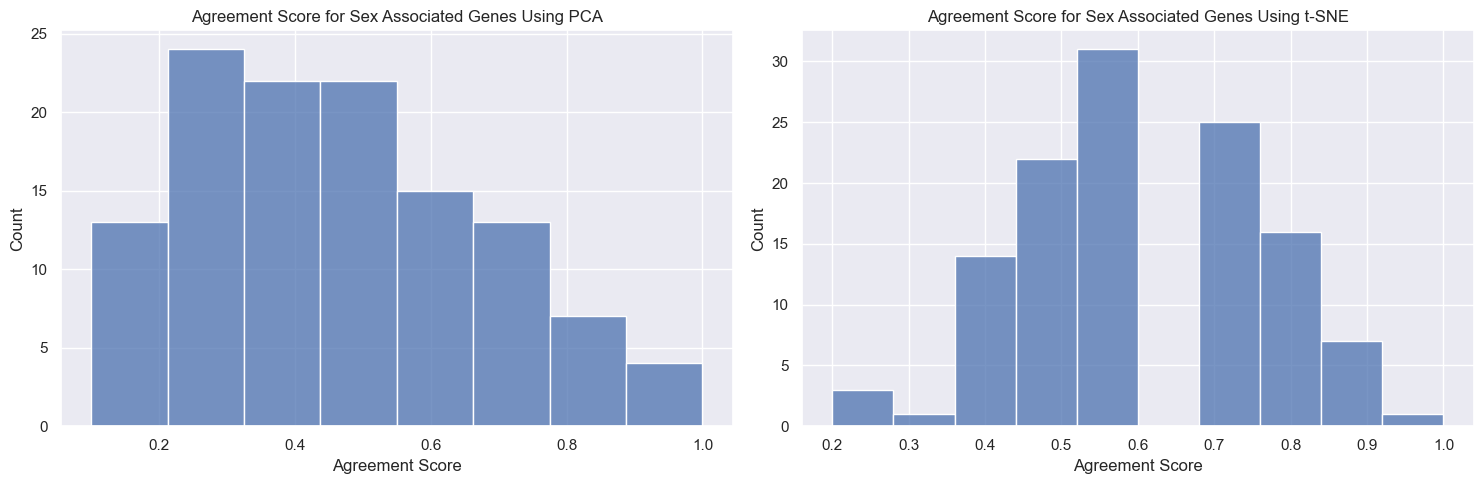

PCA Percentage of top 10 nearest neighbors retained: 0.47333333333333333
PCA Standard deviation of agreement scores: 0.1922382780706162
t-SNE Percentage of top 10 nearest neighbors retained: 0.6141666666666665
t-SNE Standard deviation of agreement scores: 0.1582697240648241


In [18]:
pca_agreement_score = compute_agreement_score(selected_genes, pca_result)
tsne_agreement_score = compute_agreement_score(selected_genes, tsne_result)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(x=pca_agreement_score, ax=axes[0])
axes[0].set_title("Agreement Score for Sex Associated Genes Using PCA")
axes[0].set_xlabel("Agreement Score")

sns.histplot(x=tsne_agreement_score, ax=axes[1])
axes[1].set_title("Agreement Score for Sex Associated Genes Using t-SNE")
axes[1].set_xlabel("Agreement Score")

plt.tight_layout()
plt.show()

print(f"PCA Percentage of top 10 nearest neighbors retained: {np.mean(pca_agreement_score)}")
print(f"PCA Standard deviation of agreement scores: {np.std(pca_agreement_score)}")
print(f"t-SNE Percentage of top 10 nearest neighbors retained: {np.mean(tsne_agreement_score)}")
print(f"t-SNE Standard deviation of agreement scores: {np.std(tsne_agreement_score)}")

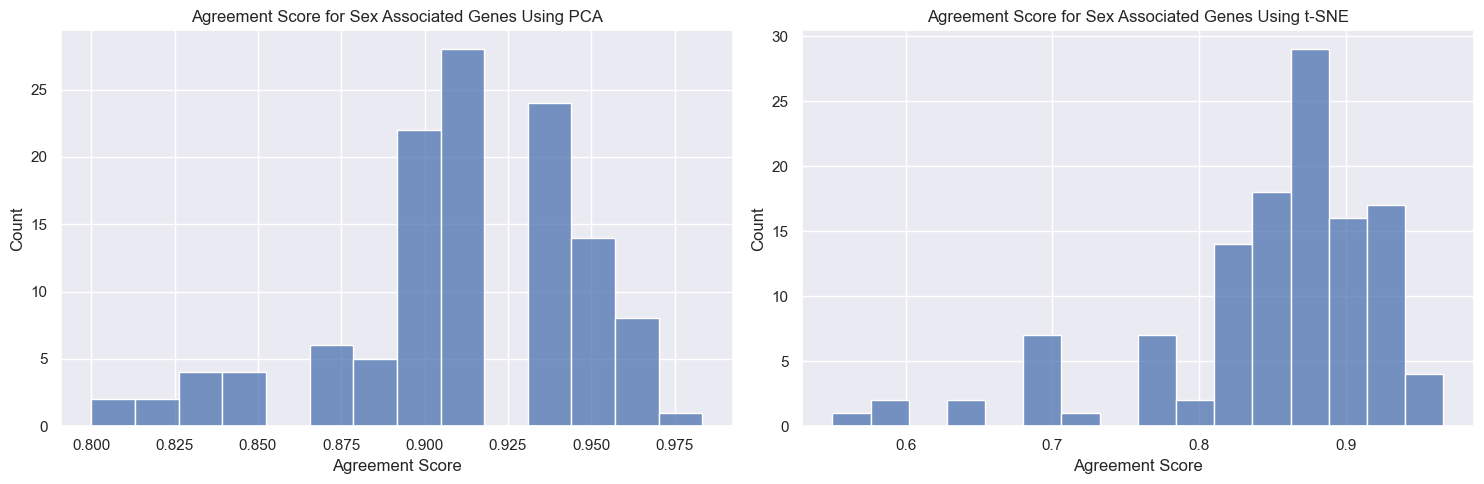

PCA Percentage of top 60 nearest neighbors retained: 0.9122222222222223
PCA Standard deviation of agreement scores: 0.03693922268862063
t-SNE Percentage of top 60 nearest neighbors retained: 0.8488888888888889
t-SNE Standard deviation of agreement scores: 0.07801748775154022


In [19]:
pca_agreement_score = compute_agreement_score(selected_genes, pca_result, n_neighbors=60)
tsne_agreement_score = compute_agreement_score(selected_genes, tsne_result, n_neighbors=60)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(x=pca_agreement_score, ax=axes[0])
axes[0].set_title("Agreement Score for Sex Associated Genes Using PCA")
axes[0].set_xlabel("Agreement Score")

sns.histplot(x=tsne_agreement_score, ax=axes[1])
axes[1].set_title("Agreement Score for Sex Associated Genes Using t-SNE")
axes[1].set_xlabel("Agreement Score")

plt.tight_layout()
plt.show()

print(f"PCA Percentage of top 60 nearest neighbors retained: {np.mean(pca_agreement_score)}")
print(f"PCA Standard deviation of agreement scores: {np.std(pca_agreement_score)}")
print(f"t-SNE Percentage of top 60 nearest neighbors retained: {np.mean(tsne_agreement_score)}")
print(f"t-SNE Standard deviation of agreement scores: {np.std(tsne_agreement_score)}")